In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import OrderedDict
import matplotlib.patches as patches
import collections
sns.set_style("white")

In [2]:
# Set some variables

family_csv = '../../181129_NB551415_0005_AHWW37BGX7/family_csvs/181129_NB551415_0005_AHWW37BGX7_all_chr_qfiltered_anno_selected_FAM001.csv'

maternal_sample = '14M01888'
proband_sample = '14M02709'
plasma_sample = 'F1-15'

gene = 'EDA'

min_genotype_depth = 30
min_distance_between_snps = 200
min_snps_per_block = 25

print ('Performing SPRT X-Linked Analysis')
print (f'The maternal sample is:\t{maternal_sample}')
print (f'The proband sample is:\t{proband_sample}')
print (f'The plasma sample is:\t{plasma_sample}')
print (f'Selected gene for analysis is:\t{gene}')
print (f'Minimum SNP genotype depth is set to:\t{min_genotype_depth}')
print (f'Minimum distance between SNPs is set to:\t{min_distance_between_snps}')
print (f'Minimum SNPs per haplotype block is set to:\t{min_snps_per_block}')

Performing SPRT X-Linked Analysis
The maternal sample is:	14M01888
The proband sample is:	14M02709
The plasma sample is:	F1-15
Selected gene for analysis is:	EDA
Minimum SNP genotype depth is set to:	30
Minimum distance between SNPs is set to:	200
Minimum SNPs per haplotype block is set to:	25


In [3]:
df = pd.read_csv(family_csv, sep='\t')

In [4]:
df.head()

,CHROM,POS,REF,ALT,ID,GENE,14M01888.GT,14M01888.AD,14M01888.DP,14M02709.GT,14M02709.AD,14M02709.DP,F1-15.GT,F1-15.AD,F1-15.DP
0,7,114498885,T,C,.,CFTR,T/T,"130,0",130,T/T,"120,0",120,T/T,"263,0",263
1,7,114499932,T,C,.,CFTR,C/C,"1,331",332,C/C,"0,419",419,C/C,"0,632",632
2,7,114537363,T,A,.,CFTR,A/A,"2,400",402,A/A,"0,477",477,A/A,"0,693",693
3,7,114539933,A,C,.,CFTR,C/C,"1,195",196,C/C,"0,155",159,C/C,"0,288",294
4,7,114559777,G,A,.,CFTR,G/G,"146,0",146,G/G,"152,0",152,G/G,"331,0",331


In [5]:
def order_columns(df):
    """
    Ensure that the columns are ordered as:
    
    CHROM, POS, REF, ALT, ID, GENE, maternal, proband, plasma

    """
    
    df = df[['CHROM',
             'POS',
             'REF',
             'ALT',
             'ID',
             'GENE',
             maternal_sample +'.GT',
             maternal_sample +'.AD',
             maternal_sample +'.DP',
             proband_sample +'.GT',
             proband_sample +'.AD',
             proband_sample +'.DP',            
             plasma_sample +'.GT',
             plasma_sample +'.AD',
             plasma_sample +'.DP',
            ]]
    
    return df

In [6]:
df = order_columns(df)

In [7]:
df.head()

,CHROM,POS,REF,ALT,ID,GENE,14M01888.GT,14M01888.AD,14M01888.DP,14M02709.GT,14M02709.AD,14M02709.DP,F1-15.GT,F1-15.AD,F1-15.DP
0,7,114498885,T,C,.,CFTR,T/T,"130,0",130,T/T,"120,0",120,T/T,"263,0",263
1,7,114499932,T,C,.,CFTR,C/C,"1,331",332,C/C,"0,419",419,C/C,"0,632",632
2,7,114537363,T,A,.,CFTR,A/A,"2,400",402,A/A,"0,477",477,A/A,"0,693",693
3,7,114539933,A,C,.,CFTR,C/C,"1,195",196,C/C,"0,155",159,C/C,"0,288",294
4,7,114559777,G,A,.,CFTR,G/G,"146,0",146,G/G,"152,0",152,G/G,"331,0",331


In [8]:
def fix_column_names(columns):
    """
    Change column names to valid python variable names by replacing '.' with '_'
    
    """
    
    fixed_columns = []
    
    for column_name in columns:
        
        fixed_column_name = column_name.replace('.', '_').replace('-', '_')
        
        if fixed_column_name not in ['CHROM', 'POS', 'REF', 'ALT','ID','GENE']:
            
            fixed_column_name = 'sample_' + fixed_column_name
        
        fixed_columns.append(fixed_column_name)
    
    return fixed_columns

In [9]:
df.columns = fix_column_names(df.columns)
maternal_sample = maternal_sample.replace('-', '_')
proband_sample = proband_sample.replace('-', '_')
plasma_sample = plasma_sample.replace('-', '_')

maternal_sample = 'sample_' + maternal_sample
proband_sample = 'sample_' + proband_sample
plasma_sample = 'sample_' + plasma_sample

In [10]:
variant_count = df.shape[0]

print (f'The initial variant count in all genes is:\t{variant_count}')

The initial variant count in all genes is:	14473


In [11]:
# Filter out low depth variants - drop entire row if any genotype depths < cut off

df = df[(df[maternal_sample + '_DP'] > min_genotype_depth) &
       (df[proband_sample + '_DP'] > min_genotype_depth) &
       (df[plasma_sample + '_DP'] > min_genotype_depth)]

variant_count = df.shape[0]
print (f'The variant count after depth filtering @ GT depth < {min_genotype_depth} in all genes is:\t{variant_count}')

The variant count after depth filtering @ GT depth < 30 in all genes is:	14336


In [12]:
# Filter out variants not in selected gene.

df = df[df['GENE'] == gene]

variant_count = df.shape[0]
print (f'The variant count in gene {gene} after depth and gene filtering is :\t{variant_count}')

The variant count in gene EDA after depth and gene filtering is :	1679


In [13]:
def genotype_sample(df, sample_name):
    """
    Return whether a sample is HOM or HET
    
    Add a NA if sample is ./. or 1/. or something else wierd
    """
    
    gt = df[sample_name+'_GT']
    
    if '/' in gt:
        
        gt = gt.split('/')
    
    elif '|' in gt:
        
        gt = gt.split('|')
        
    else:
        
        raise ValueError(f"Found a wierd genotype in variant {df['CHROM']} {df['POS']}")
        
    if (gt[0] not in 'ATGC') or (gt[1] not in 'ATGC'):
        
        return 'NA'
        
    if gt[0] == gt[1]:
        
        return 'HOM'
    else:
        return 'HET'
    
    
def get_allele_depth_ref(df, sample_name):
    """
    For a given sample split the AD column into AD for ref and alts
    
    """
    
    ad = df[sample_name+'_AD']
    
    ad = ad.split(',')
    
    return ad[0]
    
def get_allele_depth_alt(df, sample_name):
    """
    For a given sample split the AD column into AD for ref and alts
    
    """
    
    ad = df[sample_name+'_AD']
    
    ad = ad.split(',')
    
    return ad[1]


In [14]:
# Apply genotyping function

df[maternal_sample + '_call'] = df.apply(genotype_sample, axis=1, sample_name = maternal_sample )
df[proband_sample + '_call'] = df.apply(genotype_sample, axis=1, sample_name = proband_sample )
df[plasma_sample + '_call'] = df.apply(genotype_sample, axis=1, sample_name = plasma_sample )

In [15]:
# Apply genotype ref depth function

df[maternal_sample + '_AD_ref'] = df.apply(get_allele_depth_ref, axis=1, sample_name = maternal_sample )
df[proband_sample + '_AD_ref'] = df.apply(get_allele_depth_ref, axis=1, sample_name = proband_sample )
df[plasma_sample + '_AD_ref'] = df.apply(get_allele_depth_ref, axis=1, sample_name = plasma_sample )

In [16]:
# Apply genotype alt depth function

df[maternal_sample + '_AD_alt'] = df.apply(get_allele_depth_alt, axis=1, sample_name = maternal_sample )
df[proband_sample + '_AD_alt'] = df.apply(get_allele_depth_alt, axis=1, sample_name = proband_sample )
df[plasma_sample + '_AD_alt'] = df.apply(get_allele_depth_alt, axis=1, sample_name = plasma_sample )

In [17]:
df = df[(df[maternal_sample + '_call'] =='HET') &(df[proband_sample + '_call'] =='HOM') ]

variant_count = df.shape[0]
print(f'The informative variant count for gene ({gene}) after all filtering is :\t{variant_count}')

The informative variant count for gene (EDA) after all filtering is :	319


In [18]:
df.head()

,CHROM,POS,REF,ALT,ID,GENE,sample_14M01888_GT,sample_14M01888_AD,sample_14M01888_DP,sample_14M02709_GT,...,sample_F1_15_DP,sample_14M01888_call,sample_14M02709_call,sample_F1_15_call,sample_14M01888_AD_ref,sample_14M02709_AD_ref,sample_F1_15_AD_ref,sample_14M01888_AD_alt,sample_14M02709_AD_alt,sample_F1_15_AD_alt
8851,X,65115237,A,G,.,EDA,A/G,"128,128",256,G/G,...,524,HET,HOM,HET,128,1,221,128,160,303
8852,X,65121504,C,T,.,EDA,C/T,"228,207",435,T/T,...,638,HET,HOM,HET,228,1,274,207,206,364
8853,X,65124301,C,T,.,EDA,C/T,"81,60",141,T/T,...,249,HET,HOM,HET,81,0,116,60,93,133
8854,X,65125042,G,T,.,EDA,G/T,"74,58",132,T/T,...,316,HET,HOM,HET,74,0,140,58,61,176
8855,X,65126452,G,A,.,EDA,G/A,"80,77",157,A/A,...,314,HET,HOM,HET,80,0,158,77,79,156


In [19]:
df.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'ID', 'GENE', 'sample_14M01888_GT',
       'sample_14M01888_AD', 'sample_14M01888_DP', 'sample_14M02709_GT',
       'sample_14M02709_AD', 'sample_14M02709_DP', 'sample_F1_15_GT',
       'sample_F1_15_AD', 'sample_F1_15_DP', 'sample_14M01888_call',
       'sample_14M02709_call', 'sample_F1_15_call', 'sample_14M01888_AD_ref',
       'sample_14M02709_AD_ref', 'sample_F1_15_AD_ref',
       'sample_14M01888_AD_alt', 'sample_14M02709_AD_alt',
       'sample_F1_15_AD_alt'],
      dtype='object')

In [20]:
def get_hapA_counts(df, proband_sample, plasma_sample):
    """
    count the number of reads in the plasma sample which match the affected haplotype
    
    e.g. how many of the reads in the plasma match the genotype of the affected son?
    
    """
    
    # Get the genotype of the proband 
    gt = df[proband_sample+'_GT']
    
    if '/' in gt:
        
        gt = gt.split('/')
    
    elif '|' in gt:
        
        gt = gt.split('|')
        
    else:
        
        raise ValueError(f"Found a wierd genotype in variant {df['CHROM']} {df['POS']}")
    
    if gt[0] != gt[1]:
        
        raise ValueError(f"Found a wierd genotype in variant {df['CHROM']} {df['POS']}")

    gt = gt[0]
    
    # is the affected haplotype ref or alt?
    
    affected_haplotype = ''
    
    if gt == df['REF']:
        
        affected_haplotype = 'REF'
        
    elif gt == df['ALT']:
        
        affected_haplotype = 'ALT'
        
    # if the affected haplotype is the REF then get the ref AD for the plasma sample
        
    if affected_haplotype == 'REF':
        
        return df[plasma_sample+'_AD_ref']
    
    elif affected_haplotype == 'ALT':
        
        return df[plasma_sample+'_AD_alt']
    
def get_hapB_counts(df, proband_sample, plasma_sample):
    """
    count the number of reads in the plasma sample which don't match the affected haplotype
    
    
    """
                         
    gt = df[proband_sample+'_GT']
    
    if '/' in gt:
        
        gt = gt.split('/')
    
    elif '|' in gt:
        
        gt = gt.split('|')
        
    else:
        
        raise ValueError(f"Found a wierd genotype in variant {df['CHROM']} {df['POS']}")
    
    if gt[0] != gt[1]:
        
        raise ValueError(f"Found a wierd genotype in variant {df['CHROM']} {df['POS']}")

    gt = gt[0]
    
    # is the affected haplotype ref or alt?
    
    affected_haplotype = ''
    
    if gt == df['REF']:
        
        affected_haplotype = 'REF'
        
    elif gt == df['ALT']:
        
        affected_haplotype = 'ALT'
        
    # if the affected haplotype is the REF then get the ref AD for the plasma sample
        
    if affected_haplotype == 'REF':
        
        return df[plasma_sample+'_AD_alt']
    
    elif affected_haplotype == 'ALT':
        
        return df[plasma_sample+'_AD_ref']

In [21]:
df['hapA_count'] = df.apply(get_hapA_counts, axis=1, proband_sample=proband_sample, plasma_sample=plasma_sample)
df['hapB_count'] = df.apply(get_hapB_counts, axis=1, proband_sample=proband_sample, plasma_sample=plasma_sample)


In [22]:
df.tail()

,CHROM,POS,REF,ALT,ID,GENE,sample_14M01888_GT,sample_14M01888_AD,sample_14M01888_DP,sample_14M02709_GT,...,sample_14M02709_call,sample_F1_15_call,sample_14M01888_AD_ref,sample_14M02709_AD_ref,sample_F1_15_AD_ref,sample_14M01888_AD_alt,sample_14M02709_AD_alt,sample_F1_15_AD_alt,hapA_count,hapB_count
10275,X,70842778,C,T,.,EDA,C/T,"252,232",484,T/T,...,HOM,HET,252,1,397,232,255,445,445,397
10325,X,71305314,C,G,.,EDA,C/G,"231,231",462,C/C,...,HOM,HET,231,84,370,231,0,283,370,283
10477,X,71595785,A,C,.,EDA,A/C,"102,106",208,A/A,...,HOM,HET,102,43,245,106,0,185,245,185
10482,X,71788885,C,T,.,EDA,C/T,"267,236",503,T/T,...,HOM,HET,267,2,317,236,253,406,406,317
10527,X,72442984,G,A,.,EDA,G/A,"316,256",572,G/G,...,HOM,HET,316,101,535,256,0,425,535,425


In [23]:
df['hapA_count'] = pd.to_numeric(df['hapA_count'])
df['hapB_count'] = pd.to_numeric(df['hapB_count'])

In [24]:
def get_fetal_fraction_x_linked(cHapA, cHapB):
    """
    Use the formula from the Birmingham paper to calculate the fetal \
    fraction for X-linked data.
    
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4864947/
    
    cffDNA % = [(|cHapA – cHapB| * 2) / (cHapA + cHapB + |cHapA – cHapB|)] * 100
    
    """
    
    fetal_fraction = (abs(cHapA-cHapB)*2) / (cHapA + cHapB + abs(cHapA-cHapB)) *100
    
    return fetal_fraction

In [25]:
fetal_fraction = get_fetal_fraction_x_linked(df['hapA_count'].sum(), df['hapB_count'].sum())
print(fetal_fraction)

20.89836521362352


In [26]:
df.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'ID', 'GENE', 'sample_14M01888_GT',
       'sample_14M01888_AD', 'sample_14M01888_DP', 'sample_14M02709_GT',
       'sample_14M02709_AD', 'sample_14M02709_DP', 'sample_F1_15_GT',
       'sample_F1_15_AD', 'sample_F1_15_DP', 'sample_14M01888_call',
       'sample_14M02709_call', 'sample_F1_15_call', 'sample_14M01888_AD_ref',
       'sample_14M02709_AD_ref', 'sample_F1_15_AD_ref',
       'sample_14M01888_AD_alt', 'sample_14M02709_AD_alt',
       'sample_F1_15_AD_alt', 'hapA_count', 'hapB_count'],
      dtype='object')

In [27]:
def filter_snps_by_distance(df, min_distance):
    """
    filter snps so there is a minimum distance between of a certain number of basepairs.
    
    assumes df is sorted in order of position.
    
    The standard as per most SPRT/RHDO papers is a distance of 200.
    

    """
    
    snps_to_keep = []
    
    last_position = 0
    
    for snp in df.itertuples():
        
        position =  snp.POS
        
        if (position - last_position) > min_distance:
            
            snps_to_keep.append(snp)
            
            last_position = position
            
    return snps_to_keep

In [28]:
df2 = pd.DataFrame(filter_snps_by_distance(df, 200))
df2.drop('Index', inplace=True,axis=1)

In [29]:
df2.head()

,CHROM,POS,REF,ALT,ID,GENE,sample_14M01888_GT,sample_14M01888_AD,sample_14M01888_DP,sample_14M02709_GT,...,sample_14M02709_call,sample_F1_15_call,sample_14M01888_AD_ref,sample_14M02709_AD_ref,sample_F1_15_AD_ref,sample_14M01888_AD_alt,sample_14M02709_AD_alt,sample_F1_15_AD_alt,hapA_count,hapB_count
0,X,65115237,A,G,.,EDA,A/G,"128,128",256,G/G,...,HOM,HET,128,1,221,128,160,303,303,221
1,X,65121504,C,T,.,EDA,C/T,"228,207",435,T/T,...,HOM,HET,228,1,274,207,206,364,364,274
2,X,65124301,C,T,.,EDA,C/T,"81,60",141,T/T,...,HOM,HET,81,0,116,60,93,133,133,116
3,X,65125042,G,T,.,EDA,G/T,"74,58",132,T/T,...,HOM,HET,74,0,140,58,61,176,176,140
4,X,65126452,G,A,.,EDA,G/A,"80,77",157,A/A,...,HOM,HET,80,0,158,77,79,156,156,158


In [30]:
# Do SPRT both 5' to 3' and reversed
# code to actually do SPRT
# code to get blocks
# code to make plots
# since this is a panel and we sequence all the genes including autosomal - can we calculate other stats on that?
# for example -error rate and ff using X-linked - although we may not have other samples i.e. dad

In [31]:
def sprt_calculate_d(fetal_fraction):
    """
    Calculate the d value needed for SPRT analysis:
    
    See the following papers for more information:
    
    1) https://www.ncbi.nlm.nih.gov/pubmed/21148127
    
    2) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1934923/bin/pnas_0705765104_index.html
    
    The d value is used by the function sprt_perform_test()
    
    """
    
    # q0 is the allele imbalance if the null hypothesis is correct i.e. the fetus has the normal allele.
    # the 0.5 value is because we would expect to see this much deviation from the 0.5 allele balance seen \
    # in HET SNPs and then some more deviancy depending on the fetal fraction.
    
    
    q0 = 0.5 - (fetal_fraction / 2)
    
    print (q0)
    
    # q1 is the allele imbalance if the null hypothesis is incorrect i.e. the fetus has the mutant allele.

    q1 = 0.5 + (fetal_fraction / 2)
    
    print (q1)
    
    d_value = (1 - q1) / (1 - q0)
    
    return d_value

In [32]:
def sprt_calculate_g(fetal_fraction):
    """
    Calculate the g value needed for SPRT analysis:
    
    See the following papers for more information:
    
    1) https://www.ncbi.nlm.nih.gov/pubmed/21148127
    
    2) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1934923/bin/pnas_0705765104_index.html
    
    The g value is used by the function sprt_perform_test()
    
    """
    
    # q0 is the allele imbalance if the null hypothesis is correct i.e. the fetus has the normal allele.
    # the 0.5 value is because we would expect to see this much deviation from the 0.5 allele balance seen \
    # in HET SNPs and then some more deviancy depending on the fetal fraction.
    
    q0 = 0.5 - (fetal_fraction/2)

    # q1 is the allele imbalance if the null hypothesis is incorrect i.e. the fetus has the mutant allele.

    q1 = 0.5 + (fetal_fraction/2)

    g_value = ( q1*(1 - q0) ) / ( q0*(1 - q1) )
    
    return g_value

In [33]:
def sprt_calculate_upper_boundry(total_read_count, d_value, g_value):
    """
    Calculate the upper value for the SPRT classification.
    
    """
    
    return (( np.log(1200) / total_read_count ) - np.log(d_value)) / np.log(g_value)
    

In [34]:
def sprt_calculate_lower_boundry(total_read_count, d_value, g_value):
    """
    Calculate the lower value for the SPRT classification.
    
    """
    
    return (( np.log(float(1) / float(1200) )/ total_read_count ) - np.log(d_value)) / np.log(g_value)

In [35]:
def sprt_perform_test(df, d_value, g_value):
    """
    Function to call the status of each snp as hapA, hapB or Unclassified.
    
    Input:
    
    df = The processed dataframe containing the X-linked SNP data.
    d_value = The value calculated by sprt_calculate_d()
    g_value = The value calculated by sprt_calculate_g()
    
    Output:
    
    df = A new dataframe containing seven additional rows:
    
    cumulative_sum_hapa
    cumulative_sum_hapb
    cumulative_ratio
    cumulative_total
    upper_boundry
    lower_boundry
    status
    
    
    """
    
    cumulative_sum_hapa = 0
    cumulative_sum_hapb = 0
    snp_count = 0
    
    # Loop through each snp
    for snp in df.itertuples():
        
        # Calculate the cumlative sum
        cumulative_sum_hapa = cumulative_sum_hapa + snp.hapA_count
        cumulative_sum_hapb = cumulative_sum_hapb + snp.hapB_count
        
        # Calculate the cumlative allele balance between hapA and hapB
        cumulative_ratio = cumulative_sum_hapa / (cumulative_sum_hapa + cumulative_sum_hapb)
        
        cumulative_total = cumulative_sum_hapa + cumulative_sum_hapb
        
        # Calculate upper and lower SPRT boundaries
        upper_boundry = sprt_calculate_upper_boundry(cumulative_total, d_value, g_value )
        
        lower_boundry = sprt_calculate_lower_boundry(cumulative_total, d_value, g_value)
        
        # call blocks either hapA, hapB or Unclassified
        
        if (cumulative_ratio > upper_boundry) and snp_count >= min_snps_per_block:
            
            status = 'hapA'
            cumulative_sum_hapa = 0
            cumulative_sum_hapb = 0
            snp_count = 0
            
            
        elif cumulative_ratio < lower_boundry and snp_count >= min_snps_per_block:
            
            status = 'hapB'
            cumulative_sum_hapa = 0
            cumulative_sum_hapb = 0
            snp_count = 0
            
        else:
            
            status = 'Unclassified'
            
        snp_count = snp_count + 1
        
        #update dataframe with calculated values
        df.at[snp.Index, 'cumulative_sum_hapa'] = cumulative_sum_hapa
        df.at[snp.Index, 'cumulative_sum_hapb'] = cumulative_sum_hapb
        df.at[snp.Index, 'cumulative_ratio'] = cumulative_ratio
        df.at[snp.Index, 'cumulative_total'] = cumulative_total
        df.at[snp.Index, 'upper_boundry'] = upper_boundry
        df.at[snp.Index, 'lower_boundry'] = lower_boundry
        df.at[snp.Index, 'status'] = status
        
    return df

In [36]:
d_value = sprt_calculate_d(fetal_fraction / 100)
g_value = sprt_calculate_g(fetal_fraction / 100)

0.3955081739318824
0.6044918260681176


In [37]:
df_fwd = sprt_perform_test(df2, d_value, g_value)

In [38]:
df_fwd.head(50)

,CHROM,POS,REF,ALT,ID,GENE,sample_14M01888_GT,sample_14M01888_AD,sample_14M01888_DP,sample_14M02709_GT,...,sample_F1_15_AD_alt,hapA_count,hapB_count,cumulative_sum_hapa,cumulative_sum_hapb,cumulative_ratio,cumulative_total,upper_boundry,lower_boundry,status
0,X,65115237,A,G,.,EDA,A/G,"128,128",256,G/G,...,303,303,221,303.0,221.0,0.578244,524.0,0.515948,0.484052,Unclassified
1,X,65121504,C,T,.,EDA,C/T,"228,207",435,T/T,...,364,364,274,667.0,495.0,0.574010,1162.0,0.507192,0.492808,Unclassified
2,X,65124301,C,T,.,EDA,C/T,"81,60",141,T/T,...,133,133,116,800.0,611.0,0.566974,1411.0,0.505923,0.494077,Unclassified
3,X,65125042,G,T,.,EDA,G/T,"74,58",132,T/T,...,176,176,140,976.0,751.0,0.565142,1727.0,0.504839,0.495161,Unclassified
4,X,65126452,G,A,.,EDA,G/A,"80,77",157,A/A,...,156,156,158,1132.0,909.0,0.554630,2041.0,0.504094,0.495906,Unclassified
5,X,65130104,A,G,.,EDA,A/G,"157,156",313,G/G,...,267,267,225,1399.0,1134.0,0.552310,2533.0,0.503299,0.496701,Unclassified
6,X,65149157,G,A,.,EDA,G/A,"69,50",119,A/A,...,128,128,104,1527.0,1238.0,0.552260,2765.0,0.503022,0.496978,Unclassified
7,X,65167272,G,A,.,EDA,G/A,"336,258",594,A/A,...,458,458,366,1985.0,1604.0,0.553079,3589.0,0.502328,0.497672,Unclassified
8,X,65179142,A,G,.,EDA,A/G,"64,48",112,G/G,...,114,114,111,2099.0,1715.0,0.550341,3814.0,0.502191,0.497809,Unclassified
9,X,65180462,A,T,.,EDA,A/T,"203,159",362,T/T,...,345,345,277,2444.0,1992.0,0.550947,4436.0,0.501884,0.498116,Unclassified


In [39]:
def call_blocks(df):
    
    block_df = []
    
    prev_status = 'Unclassified'
    snp_count = 0
    block_id = 0
    first = True
    
    for snp in df.itertuples():
        
        if first == True:
            
            prev_pos = snp.POS
            first = False
        
        status = snp.status
        
        if status != prev_status:
            
            block_df.append([block_id, prev_pos, snp.POS, snp_count, status])
            
            prev_pos = snp.POS
            snp_count = 0
            block_id = block_id + 1
        
            
        snp_count = snp_count + 1
        
    return block_df

In [40]:
blocks_fwd = call_blocks(df_fwd)
print (blocks_fwd)

[[0, 65115237, 65253769, 25, 'hapA'], [1, 65253769, 67318954, 25, 'hapA'], [2, 67318954, 67393611, 25, 'hapA'], [3, 67393611, 68384125, 25, 'hapA'], [4, 68384125, 68513831, 25, 'hapA'], [5, 68513831, 68579510, 25, 'hapA'], [6, 68579510, 68735079, 25, 'hapA'], [7, 68735079, 69025671, 25, 'hapA'], [8, 69025671, 69197561, 25, 'hapA'], [9, 69197561, 69884697, 25, 'hapA']]


In [41]:
# Do SPRT in reverse

df_rev = sprt_perform_test(df2.sort_values(by='POS', ascending=False), d_value, g_value)

blocks_rev = call_blocks(df_rev)

print (blocks_rev)

mean_snps_per_block = np.mean([x[3] for x in blocks_fwd] + [x[3] for x in blocks_rev])
hapas = [x[4] for x in blocks_fwd] + [x[4] for x in blocks_rev]

print ('')
print(f'The mean number of snps per Haplotype block is {mean_snps_per_block:.2f}')
print(collections.Counter(hapas))

[[0, 72442984, 69401419, 25, 'hapA'], [1, 69401419, 69168733, 25, 'hapA'], [2, 69168733, 68783558, 25, 'hapA'], [3, 68783558, 68692214, 25, 'hapA'], [4, 68692214, 68537987, 25, 'hapA'], [5, 68537987, 68475676, 25, 'hapA'], [6, 68475676, 68029074, 25, 'hapA'], [7, 68029074, 67371802, 25, 'hapA'], [8, 67371802, 65329887, 25, 'hapA'], [9, 65329887, 65207701, 25, 'hapA']]

The mean number of snps per Haplotype block is 25.00
Counter({'hapA': 20})


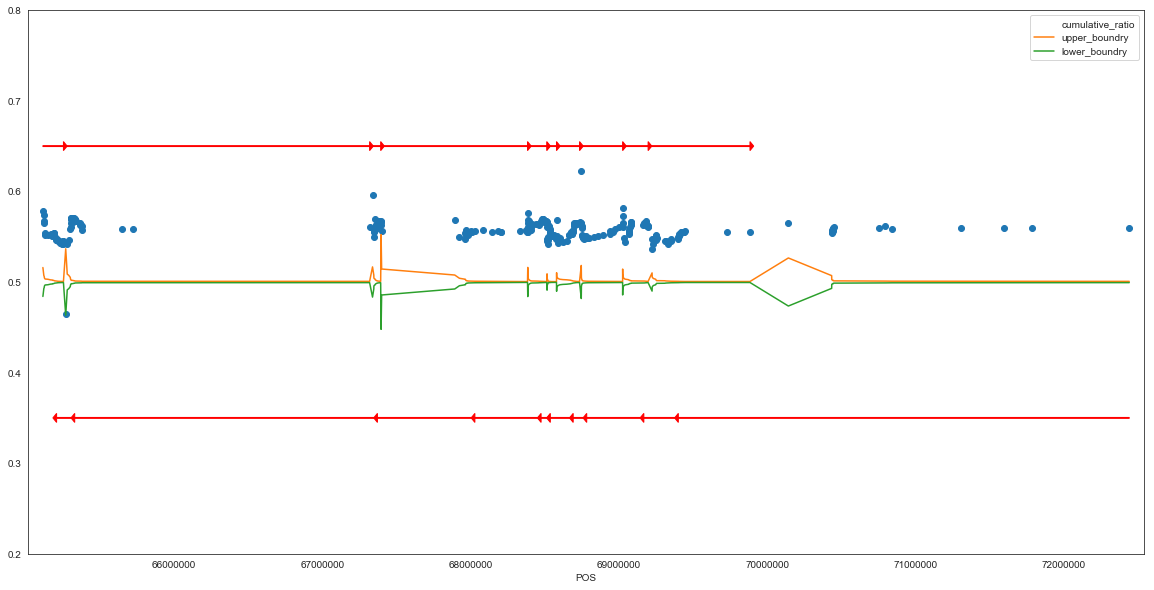

In [42]:

fig, ax = plt.subplots(figsize=(20,10))

df_fwd.plot(x='POS', y='cumulative_ratio', kind='line', style='o', ax=ax)
df_fwd.plot(x='POS',y='upper_boundry', kind='line', ax=ax )
df_fwd.plot(x='POS',y='lower_boundry', kind='line', ax=ax)


ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.set_ylim([0.2,0.8])

ax.set_xlim(df['POS'].min()-100000, df['POS'].max()+100000)


for x in call_blocks(df_fwd):
    
    if x[4] == 'hapA':

        ax.arrow(x[1], 0.65, (x[2]-x[1]), 0, head_width=0.01, head_length=25000, color='red')
        
    elif x[4] == 'hapB':
        
        ax.arrow(x[1], 0.65, (x[2]-x[1]), 0, head_width=0.01, head_length=25000, color='blue')

    else:
        
        ax.arrow(x[1], 0.65, (x[2]-x[1]), 0, head_width=0.01, head_length=25000, color='yellow')
        

for x in call_blocks(df_rev):
    
    if x[4] == 'hapA':

        ax.arrow(x[1], 0.35, (x[2]-x[1]), 0, head_width=0.01, head_length=25000, color='red')
        
    elif x[4] == 'hapB':
        
        ax.arrow(x[1], 0.35, (x[2]-x[1]), 0, head_width=0.01, head_length=25000, color='blue')

    else:
        
        ax.arrow(x[1], 0.35, (x[2]-x[1]), 0, head_width=0.01, head_length=25000, color='yellow')
        
        
ax.scatter(152791586,0.25, c='green')

In [43]:
df2.head()

,CHROM,POS,REF,ALT,ID,GENE,sample_14M01888_GT,sample_14M01888_AD,sample_14M01888_DP,sample_14M02709_GT,...,sample_F1_15_AD_alt,hapA_count,hapB_count,cumulative_sum_hapa,cumulative_sum_hapb,cumulative_ratio,cumulative_total,upper_boundry,lower_boundry,status
0,X,65115237,A,G,.,EDA,A/G,"128,128",256,G/G,...,303,303,221,303.0,221.0,0.578244,524.0,0.515948,0.484052,Unclassified
1,X,65121504,C,T,.,EDA,C/T,"228,207",435,T/T,...,364,364,274,667.0,495.0,0.574010,1162.0,0.507192,0.492808,Unclassified
2,X,65124301,C,T,.,EDA,C/T,"81,60",141,T/T,...,133,133,116,800.0,611.0,0.566974,1411.0,0.505923,0.494077,Unclassified
3,X,65125042,G,T,.,EDA,G/T,"74,58",132,T/T,...,176,176,140,976.0,751.0,0.565142,1727.0,0.504839,0.495161,Unclassified
4,X,65126452,G,A,.,EDA,G/A,"80,77",157,A/A,...,156,156,158,1132.0,909.0,0.554630,2041.0,0.504094,0.495906,Unclassified


In [44]:
sns.distplot(df2['hapA_count'] +)

SyntaxError: invalid syntax (<ipython-input-44-89ec220ec085>, line 1)

In [ ]:
sns.distplot(df2['hapA_count'] + df2['hapB_count'])

In [ ]:
print(np.mean(df2['hapA_count'] + df2['hapB_count']))
print(np.std(df2['hapA_count'] + df2['hapB_count']))

In [ ]:
abs(np.random.normal(100,30, size=1))

In [ ]:
df2.head()

In [ ]:
sns.distplot(df2['hapA_count'] / df2['hapB_count'])